In [1]:
import os
import pandas as pd
import seaborn as sns
import requests
from googleapiclient.discovery import build

from dotenv import load_dotenv
load_dotenv()

True

Find channel IDs and set them into a list

In [2]:
#Just a bit of setup for the project
api_key = os.environ.get('YOUTUBE_INSIGHTS_API_KEY')

channel_ids = ['UCAiLfjNXkNv24uhpzUgPa6A', #MrBeast Philanthropy
               'UCUaT_39o1x6qWjz7K2pWcgw', #Beast Reacts
               'UCgoFStVyEsm8tBZP5NC-aBQ', #MrBeast
               'UC4-79UOlP48-QNGgCko5p2g', #MrBeast 2
               'UCIPPMRA040LQr5QPyJEbmXA'  #MrBeast Gaming
               ]
         

channel_id = 'UCgoFStVyEsm8tBZP5NC-aBQ'
youtube = build('youtube', 'v3', developerKey=api_key)

In [3]:
# #MrBeast custom URL was returning values that weren't consistent with statistics on the channel page
# #Here I am attempting to extract the channel ID

# url = "https://www.googleapis.com/youtube/v3/channels"
# params = {
#     'part': 'snippet',
#     'forUsername': 'MrBeast',
#     'key': api_key
# }

# response = requests.get(url, params=params)


In [4]:

# Check the response status code to see if the request was successful
# if response.status_code == 200:
#     # If the request was successful, check if the 'items' key is in the response
#     if 'items' in response.json():
#         channel_id = response.json()['items'][0]['id']
#         print(channel_id)
#     else:
#         # If the 'items' key is not in the response, the channel may not have been found
#         print("The channel was not found.")
# else:
#     # If the request was unsuccessful, you may need to check the API key or URL
#     print("An error occurred while trying to retrieve the channel ID.")
 
##Channel ID still yielded values inconsistent with the channel page. I'll just have to work with what I've got for now

## Get Channel Statistics

In [5]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, Statistics',
        id=','.join(channel_ids))
    response=request.execute()

    for i in range(len(response['items'])):
        data = dict(Channel_Name = response['items'][i]['snippet']['title'],
                Subscribers = response['items'][i]['statistics']['subscriberCount'],
                Views = response['items'][i]['statistics']['viewCount'],
                Total_videos = response['items'][i]['statistics']['videoCount'],
                playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        
        all_data.append(data)
    
    return all_data

In [6]:
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_statistics

[{'Channel_Name': 'MrBeast 2',
  'Subscribers': '18900000',
  'Views': '2833245998',
  'Total_videos': '108',
  'playlist_id': 'UU4-79UOlP48-QNGgCko5p2g'},
 {'Channel_Name': 'Beast Philanthropy',
  'Subscribers': '11700000',
  'Views': '177874480',
  'Total_videos': '20',
  'playlist_id': 'UUAiLfjNXkNv24uhpzUgPa6A'},
 {'Channel_Name': 'MrBeast Gaming',
  'Subscribers': '31100000',
  'Views': '5469465100',
  'Total_videos': '138',
  'playlist_id': 'UUIPPMRA040LQr5QPyJEbmXA'},
 {'Channel_Name': 'MrBeast',
  'Subscribers': '1630',
  'Views': '67283',
  'Total_videos': '3',
  'playlist_id': 'UUgoFStVyEsm8tBZP5NC-aBQ'},
 {'Channel_Name': 'Beast Reacts',
  'Subscribers': '21600000',
  'Views': '3287603708',
  'Total_videos': '232',
  'playlist_id': 'UUUaT_39o1x6qWjz7K2pWcgw'}]

In [7]:
channel_data = pd.DataFrame(channel_statistics)
channel_data

,Channel_Name,Subscribers,Views,Total_videos,playlist_id
0,MrBeast 2,18900000,2833245998,108,UU4-79UOlP48-QNGgCko5p2g
1,Beast Philanthropy,11700000,177874480,20,UUAiLfjNXkNv24uhpzUgPa6A
2,MrBeast Gaming,31100000,5469465100,138,UUIPPMRA040LQr5QPyJEbmXA
3,MrBeast,1630,67283,3,UUgoFStVyEsm8tBZP5NC-aBQ
4,Beast Reacts,21600000,3287603708,232,UUUaT_39o1x6qWjz7K2pWcgw


Organize and Viualize Data

In [8]:
channel_data['Channel_Name']= channel_data['Channel_Name'].astype(str)
channel_data['Subscribers']= channel_data['Subscribers'].astype('int64')
channel_data['Views']= channel_data['Views'].astype('int64')
channel_data['Total_videos']= channel_data['Total_videos'].astype('int64')

In [9]:
channel_data.sort_values(by='Subscribers', ascending=False, inplace=True)
channel_data.dtypes

Channel_Name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

Text(0, 0.5, 'Subscribers in Ten Millions')

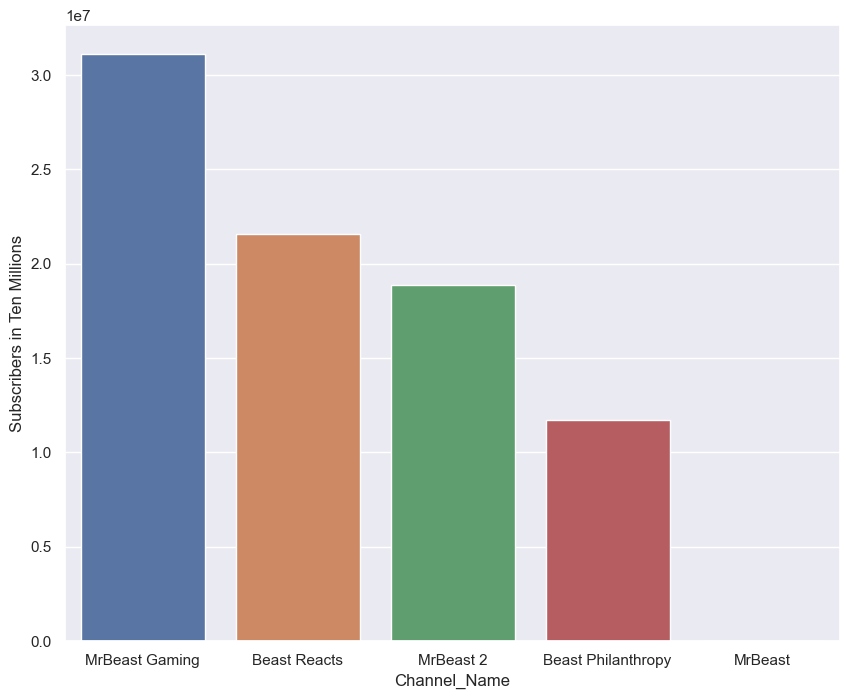

In [10]:
sns.set(rc={'figure.figsize':(10,8)})
channel_data.sort_values(by='Subscribers', ascending=False, inplace=False)
ax = sns.barplot(x='Channel_Name', y='Subscribers', data=channel_data)
ax.set_ylabel("Subscribers in Ten Millions")

Text(0, 0.5, 'Views in Billions')

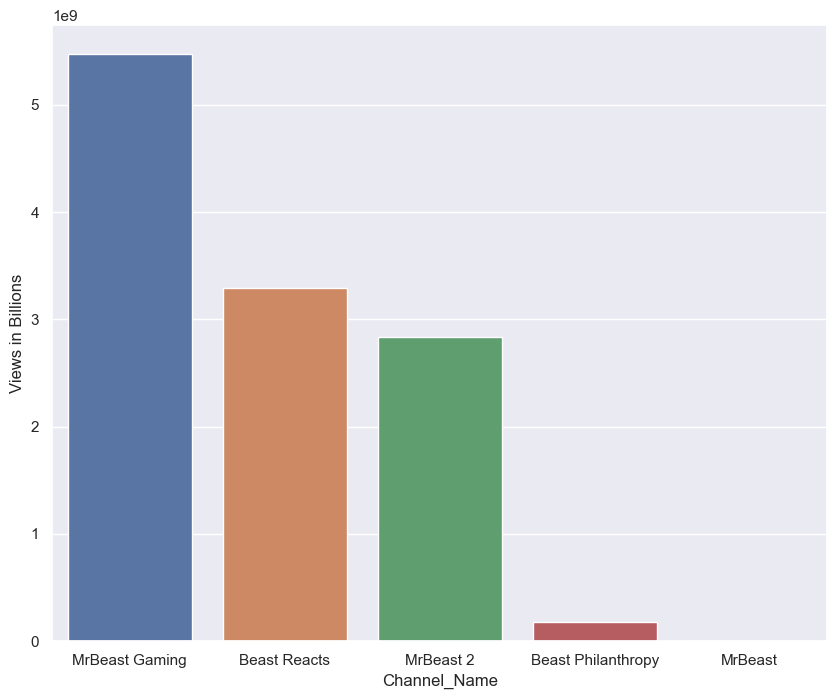

In [11]:
ax = sns.barplot(x='Channel_Name', y='Views', data=channel_data)
ax.set_ylabel("Views in Billions")

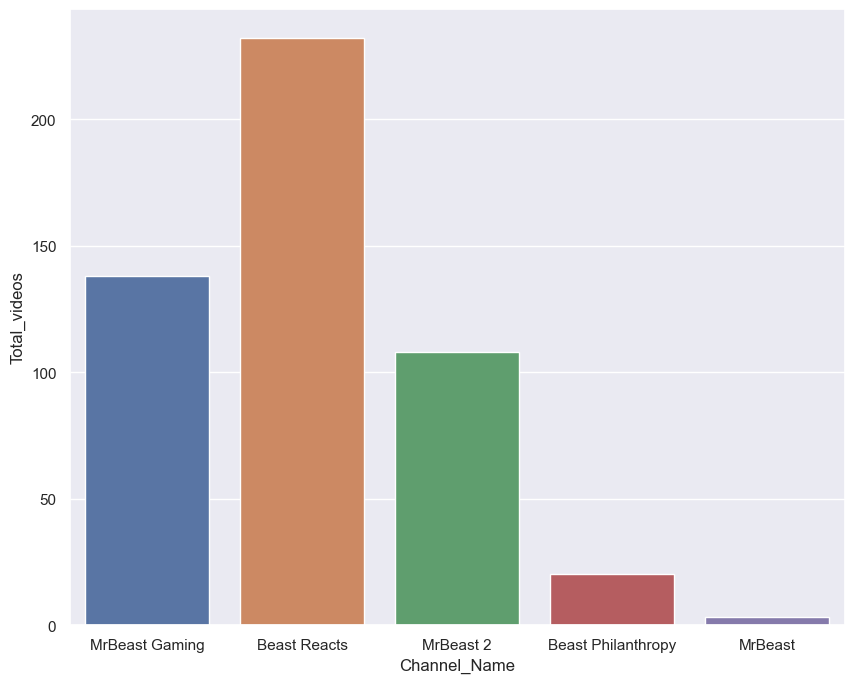

In [17]:
ax = sns.barplot(x='Channel_Name', y='Total_videos', data=channel_data)

In [18]:
channel_data

,Channel_Name,Subscribers,Views,Total_videos,playlist_id
2,MrBeast Gaming,31100000,5469465100,138,UUIPPMRA040LQr5QPyJEbmXA
4,Beast Reacts,21600000,3287603708,232,UUUaT_39o1x6qWjz7K2pWcgw
0,MrBeast 2,18900000,2833245998,108,UU4-79UOlP48-QNGgCko5p2g
1,Beast Philanthropy,11700000,177874480,20,UUAiLfjNXkNv24uhpzUgPa6A
3,MrBeast,1630,67283,3,UUgoFStVyEsm8tBZP5NC-aBQ
